# Part 2: Praproses dan Pelabelan Data Review Tokopedia

Notebook ini berisi kode untuk melakukan praproses dan pelabelan data review Tokopedia yang telah di-scraping.

## Import Library yang Diperlukan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

## Download Paket NLTK yang Diperlukan

In [3]:
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

## Memuat Data yang Telah di-Scraping

In [4]:
# Memuat data dari file CSV
df_reviews = pd.read_csv('tokopedia_reviews_raw.csv')

# Melihat 5 data pertama
df_reviews.head()

,content,score,at
0,apk tidak bisa beri ulasan barang yg sdh diter...,1,2025-03-19 21:22:48
1,bagus banget ini,5,2025-03-19 21:11:09
2,mantap,5,2025-03-19 21:10:00
3,aku nyaman banget di tokped keren ongkir grati...,5,2025-03-19 21:04:54
4,kurang gratis ongkir aja,5,2025-03-19 20:59:59


## Pelabelan Data Berdasarkan Score

In [5]:
def label_sentiment(score):
    if score >= 4:  # Rating 4-5 sebagai sentimen positif
        return 'positive'
    elif score <= 2:  # Rating 1-2 sebagai sentimen negatif
        return 'negative'
    else:  # Rating 3 sebagai sentimen netral
        return 'neutral'

# Aplikasikan fungsi pelabelan ke kolom 'score'
df_reviews['sentiment'] = df_reviews['score'].apply(label_sentiment)

# Melihat contoh data setelah pelabelan
df_reviews[['content', 'score', 'sentiment']].head()

,content,score,sentiment
0,apk tidak bisa beri ulasan barang yg sdh diter...,1,negative
1,bagus banget ini,5,positive
2,mantap,5,positive
3,aku nyaman banget di tokped keren ongkir grati...,5,positive
4,kurang gratis ongkir aja,5,positive


## Visualisasi Distribusi Sentimen

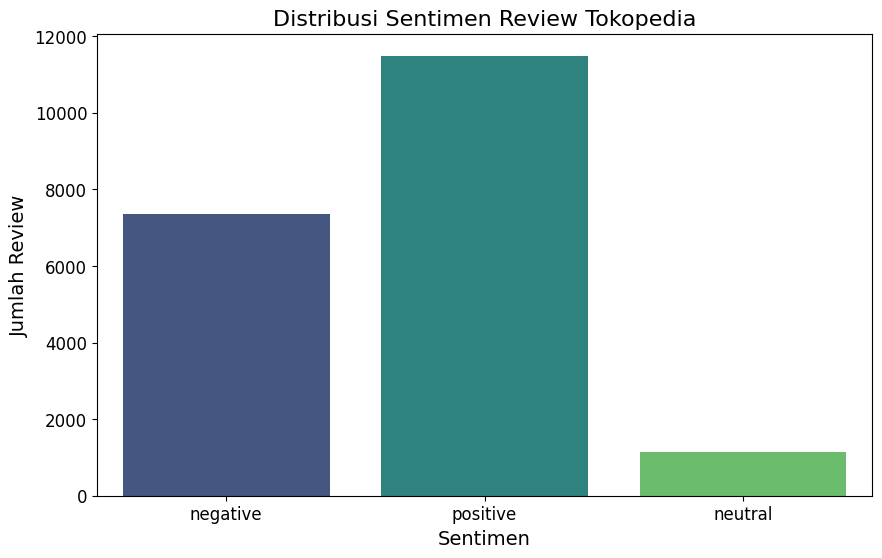

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df_reviews, palette='viridis')
plt.title('Distribusi Sentimen Review Tokopedia', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Jumlah Review', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
# Persentase sentimen
sentiment_counts = df_reviews['sentiment'].value_counts(normalize=True) * 100
print("Persentase Sentimen:")
for sentiment, percentage in sentiment_counts.items():
    print(f"{sentiment}: {percentage:.2f}%")

Persentase Sentimen:
positive: 57.45%
negative: 36.82%
neutral: 5.73%


## Praproses Teks Review

In [8]:
def preprocess_text(text):
    # Cek jika text adalah string
    if not isinstance(text, str):
        return ''
    
    # Konversi ke huruf kecil
    text = text.lower()
    
    # Hapus URL
    text = re.sub(r'http\S+', '', text)
    
    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    
    # Tokenisasi
    tokens = word_tokenize(text)
    
    # Filter stopwords
    stop_words = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Gabung kembali
    return ' '.join(tokens)

In [9]:
# Terapkan praproses pada kolom 'content'
df_reviews['processed_content'] = df_reviews['content'].apply(preprocess_text)

# Melihat contoh data setelah praproses
df_reviews[['content', 'processed_content', 'sentiment']].head()

,content,processed_content,sentiment
0,apk tidak bisa beri ulasan barang yg sdh diter...,apk ulasan barang yg sdh diterima pake devic r...,negative
1,bagus banget ini,bagu banget,positive
2,mantap,mantap,positive
3,aku nyaman banget di tokped keren ongkir grati...,nyaman banget tokp keren ongkir grati bonu,positive
4,kurang gratis ongkir aja,grati ongkir aja,positive


## Bersihkan Data Kosong

In [10]:
# Cek jumlah data sebelum pembersihan
print(f"Jumlah data sebelum pembersihan: {len(df_reviews)}")

# Hapus baris dengan konten kosong setelah praproses
df_reviews = df_reviews[df_reviews['processed_content'] != '']

# Cek jumlah data setelah pembersihan
print(f"Jumlah data setelah pembersihan: {len(df_reviews)}")

Jumlah data sebelum pembersihan: 20000
Jumlah data setelah pembersihan: 19718


## Visualisasi Kata-kata Umum dengan WordCloud

In [11]:
# Buat dataset untuk binary sentiment (positif dan negatif saja)
df_binary = df_reviews[df_reviews['sentiment'] != 'neutral']

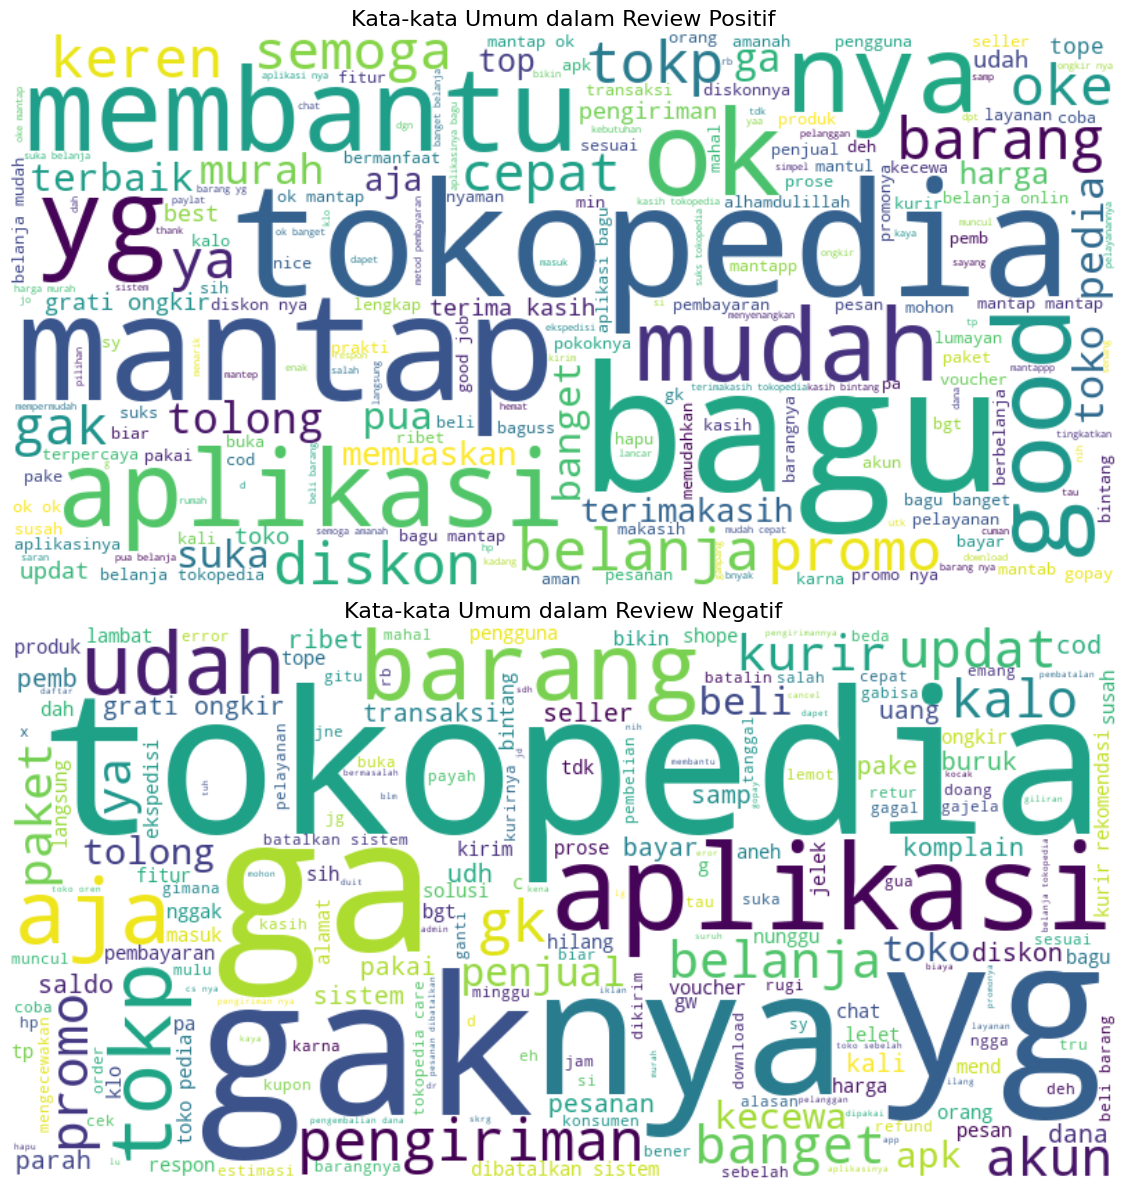

In [12]:
plt.figure(figsize=(12, 12))

# Word cloud untuk sentimen positif
positive_text = ' '.join(df_binary[df_binary['sentiment'] == 'positive']['processed_content'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.subplot(2, 1, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Kata-kata Umum dalam Review Positif', fontsize=16)

# Word cloud untuk sentimen negatif
negative_text = ' '.join(df_binary[df_binary['sentiment'] == 'negative']['processed_content'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Kata-kata Umum dalam Review Negatif', fontsize=16)

plt.tight_layout()
plt.show()

## Fitur Tambahan: Panjang Review

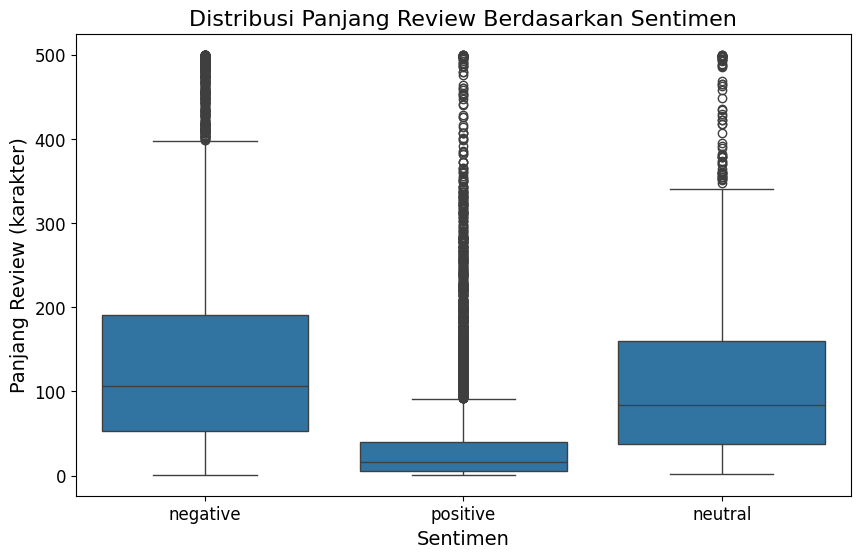

In [13]:
# Tambahkan fitur panjang review
df_reviews['review_length'] = df_reviews['content'].apply(len)

# Melihat distribusi panjang review berdasarkan sentimen
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df_reviews)
plt.title('Distribusi Panjang Review Berdasarkan Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Panjang Review (karakter)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Simpan Data yang Telah Diproses

In [14]:
# Simpan data yang telah diproses
df_reviews.to_csv('tokopedia_reviews_processed.csv', index=False)
print("Data berhasil disimpan ke 'tokopedia_reviews_processed.csv'")

# Simpan data binary sentiment
df_binary.to_csv('tokopedia_reviews_binary.csv', index=False)
print("Data binary sentiment berhasil disimpan ke 'tokopedia_reviews_binary.csv'")

Data berhasil disimpan ke 'tokopedia_reviews_processed.csv'
Data binary sentiment berhasil disimpan ke 'tokopedia_reviews_binary.csv'


In [15]:
# Import Library yang Diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Memuat Data yang Telah Diproses
df_binary = pd.read_csv('tokopedia_reviews_binary.csv')
print(df_binary.head())


                                             content  score  \
0  apk tidak bisa beri ulasan barang yg sdh diter...      1   
1                                   bagus banget ini      5   
2                                             mantap      5   
3  aku nyaman banget di tokped keren ongkir grati...      5   
4                           kurang gratis ongkir aja      5   

                    at sentiment  \
0  2025-03-19 21:22:48  negative   
1  2025-03-19 21:11:09  positive   
2  2025-03-19 21:10:00  positive   
3  2025-03-19 21:04:54  positive   
4  2025-03-19 20:59:59  positive   

                                   processed_content  
0  apk ulasan barang yg sdh diterima pake devic r...  
1                                        bagu banget  
2                                             mantap  
3         nyaman banget tokp keren ongkir grati bonu  
4                                   grati ongkir aja  


Distribusi Sentimen:
sentiment
positive    11224
negative     7361
Name: count, dtype: int64


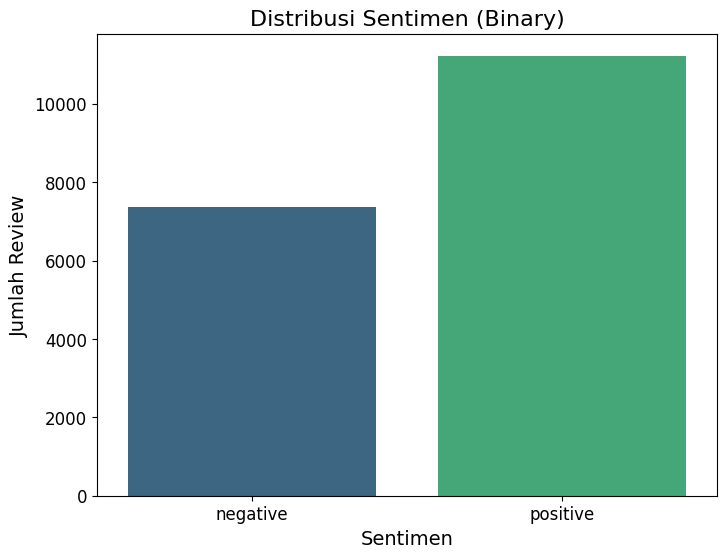

In [17]:
# Analisis Distribusi Data
sentiment_counts = df_binary['sentiment'].value_counts()
print("Distribusi Sentimen:")
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_binary, palette='viridis')
plt.title('Distribusi Sentimen (Binary)', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Jumlah Review', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [18]:
# Ekstraksi Fitur dengan TF-IDF
X = df_binary['processed_content']
y = df_binary['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Ukuran matriks fitur TF-IDF training: {X_train_tfidf.shape}")
print(f"Ukuran matriks fitur TF-IDF testing: {X_test_tfidf.shape}")

Jumlah data training: 14868
Jumlah data testing: 3717
Ukuran matriks fitur TF-IDF training: (14868, 5000)
Ukuran matriks fitur TF-IDF testing: (3717, 5000)


In [19]:
#dengan N-gram
tfidf_ngram_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train_tfidf_ngram = tfidf_ngram_vectorizer.fit_transform(X_train)
X_test_tfidf_ngram = tfidf_ngram_vectorizer.transform(X_test)
print(f"Ukuran matriks fitur TF-IDF N-gram training: {X_train_tfidf_ngram.shape}")
print(f"Ukuran matriks fitur TF-IDF N-gram testing: {X_test_tfidf_ngram.shape}")

Ukuran matriks fitur TF-IDF N-gram training: (14868, 5000)
Ukuran matriks fitur TF-IDF N-gram testing: (3717, 5000)


In [20]:
# Ekstraksi Fitur dengan Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
print(f"Ukuran matriks fitur Bag of Words training: {X_train_bow.shape}")
print(f"Ukuran matriks fitur Bag of Words testing: {X_test_bow.shape}")

Ukuran matriks fitur Bag of Words training: (14868, 5000)
Ukuran matriks fitur Bag of Words testing: (3717, 5000)


In [21]:
# Menganalisis Kata Penting dalam Fitur TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sorting = np.argsort(tfidf_vectorizer.idf_)[::-1]
features_importance = [(feature_names[i], tfidf_vectorizer.idf_[i]) for i in tfidf_sorting[:20]]
print("20 Kata Penting Berdasarkan TF-IDF:")
for feature, importance in features_importance:
    print(f"{feature}: {importance:.4f}")

20 Kata Penting Berdasarkan TF-IDF:
𝚝𝚒𝚗𝚐𝚐𝚊𝚕: 9.9139
abis²: 9.9139
𝚕𝚎𝚗𝚐𝚔𝚊𝚙: 9.9139
𝚕𝚊𝚣𝚊𝚍𝚊: 9.9139
𝚕𝚊𝚒𝚗: 9.9139
𝚓𝚕𝚗: 9.9139
𝚐𝚒𝚗𝚒: 9.9139
𝚐𝚊𝚔: 9.9139
𝚍𝚞𝚜𝚞𝚗: 9.9139
𝚊𝚖𝚊𝚝: 9.9139
𝚊𝚕𝚖𝚊𝚝: 9.9139
𝚂𝚊𝚢𝚊: 9.9139
𝙷𝚊𝚢: 9.9139
𝙳𝚊𝚏𝚝𝚊𝚛: 9.9139
yuliana: 9.9139
abiz: 9.9139
aba: 9.9139
ws: 9.9139
cepetlah: 9.9139
cepetbanyak: 9.9139


In [22]:
# Simpan data fitur dan label untuk pelatihan model
import pickle
with open('tokopedia_tfidf_features.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train_tfidf, 'X_test': X_test_tfidf, 'y_train': y_train, 'y_test': y_test, 'vectorizer': tfidf_vectorizer}, f)
print("Data fitur TF-IDF berhasil disimpan ke 'tokopedia_tfidf_features.pkl'")

Data fitur TF-IDF berhasil disimpan ke 'tokopedia_tfidf_features.pkl'
